# Searching the best algorithm to predict the Amazon review ratings

In this notebook I'm going to analyze the performance of different Machine Learning algorithms to find out the best model for this exercise. As in other notebooks, I will begin importing the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

from functions.nlp import cleaning_review
from functions.preproc import tfidf,svc_dimred
from functions.automl import BestClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ordovas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ordovas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I will load a subset of the database (stored in a MongoDB collection) and loading the same ammount of reviews for each rating.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
df=pd.DataFrame()
for i in range(1,6):
    res = list(books.aggregate([{"$match":{"overall":i}},
        { "$sample": { "size": 10000 }},
        { "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} ]))
    # Converting to pandas DataFrame
    dft=pd.DataFrame(res)

    dft=dft.dropna().reset_index()
    df=df.append(dft)

df=df.reset_index()
df["overall"].value_counts()

2    10000
4     9998
3     9998
1     9998
5     9997
Name: overall, dtype: int64

And now I will clean the text of the reviews (lemmatizing the text, removing punctuation and stop words), divide the dataset into train and test samples and create the TF-IDF vectors for the cleaned text. After that, I will reduce the dimensionality of the TF-IDF vectors using 500 dimensions.

In [3]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)

Xraw_train, Xraw_test, y_train, y_test = train_test_split(df, df["overall"],
                                                          test_size=0.15, random_state=42)
Xtfidf_train , Xtfidf_test= tfidf(Xraw_train["review_clean"], Xraw_test["review_clean"],5)
comps,var,svd_transformer = svc_dimred(Xtfidf_train,500)
X_train = svd_transformer.transform(Xtfidf_train)
X_test = svd_transformer.transform(Xtfidf_test)

In [4]:
Xraw_train.head()

,level_0,index,overall,reviewerName,reviewText,summary,id,review_clean
28170,8172,8174,3,R. Murphy,This would have merited a higher rating if it ...,A bit over-long in parts,6033ab75f7ccad4a92f24081,this would merited higher rating middle third ...
32803,2807,2807,4,Amazon Customer,So far so good. I haven't finished the novel ...,Innocence,6033ab8af7ccad4a92f67d4b,so far good finished novel yet far engaging ko...
38580,8584,8586,4,Michael L. Shanks,"FIVE STARS for ""Seveneves"", for ideas, but I'...",FOUR STARS - and Why I didn't give it a FIVE.,6033ab91f7ccad4a92f7e870,five star seveneves idea take away execution s...
31785,1789,1789,4,Joanna Damons,Really good depiction of what non-radicle musl...,Four Stars,6033ab7bf7ccad4a92f37a50,really good depiction non radicle muslim must ...
7893,7893,7895,1,Janelle,I wish I had just read the reviews and not bo...,the reviews are more entertaining than the book,6033ab73f7ccad4a92f1eb7b,i wish read review bothered book many somehow ...


Now let's find out what is the best ML algorithm for this problem. 

I will import a class that I've created previously, that is the one called `BestClassifier`. This one requires the input train features (X_train), the target (y_train) and a list of models to analyze its performance (see `functions/automl.py` to see how it works). It will store the best fitting ML model among the best fitting parameters for each model. `BestClassifier` will have a `.fit(X,y)`, `.predict(X)`, `.predict_proba(X)` and `.score(X,y)` functions as any other classifier, but with the best model with the best performance parameters.

In [5]:
clf=BestClassifier(X_train,y_train,[ "LogisticRegression","LinearSVC","SGDClassifier",
                             "KNeighborsClassifier","RandomForestClassifier","GaussianNB"])

Analyzing LogisticRegression
Score = 0.47907860963859605
Analyzing LinearSVC
Score = 0.47554845584120475
Analyzing SGDClassifier
Score = 0.4456367314239148
Analyzing KNeighborsClassifier
Score = 0.3322273430144247
Analyzing RandomForestClassifier
Score = 0.36830477003496676
Analyzing GaussianNB
Score = 0.346441621708932
Best model:
LogisticRegression(class_weight='balanced', max_iter=10000)


The train and test scores for the best classifier are the following:

In [6]:
clf.score(X_train,y_train),clf.score(X_test,y_test)

(0.5060011296243999, 0.4932657687691692)

The histogram of the performance of the model is plotted below:

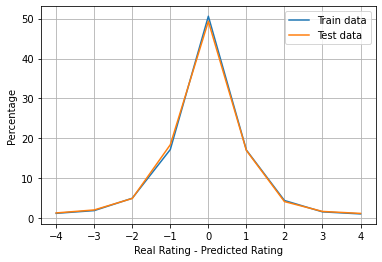

In [37]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

And finally, the confusion matrices of the best model are the following:

Train subsample:


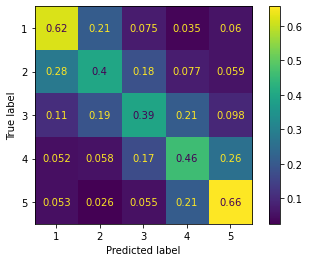

Test subsample:


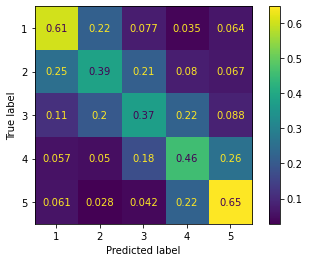

In [7]:
print("Train subsample:")
plot_confusion_matrix(clf.bestclassifier_, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf.bestclassifier_, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

### Let's check the results...

We are happy enough with the model we've chosen and its performance, so now we can see the raw reviews and check out their predictions.

The majority of the results are accurate or fails in 1 point. Let's check one of the predictions that are accurate.

In [24]:
res_train = Xraw_train.copy()
res_train["predictions"]=clf.predict(X_train)
res_train=res_train.drop(columns=['level_0', 'index'])
res_test = Xraw_test.copy()
res_test["predictions"]=clf.predict(X_test)
res_test=res_test.drop(columns=['level_0', 'index'])

In [25]:
testing = res_test[(res_test["overall"] == 5) & (res_test["predictions"] == 5)  ]
testing=testing.reset_index()
testing.head()

,index,overall,reviewerName,reviewText,summary,id,review_clean,predictions
0,41382,5,Amazon Customer,love this book,Five Stars,6033ab7af7ccad4a92f32913,love book,5
1,46948,5,Jar,"Although not familiar with a Wicca or a Magus,...",All Of Life's Journey Is Good,6033ab7ff7ccad4a92f429c9,although familiar wicca magus became comfortab...,5
2,49741,5,CAE2,Excellent continuation of a series,Five Stars,6033ab82f7ccad4a92f4ce44,excellent continuation series,5
3,49238,5,Fred A.,House of Spies continues the adventures of Gab...,Will we have to wait another year?,6033ab91f7ccad4a92f7fa2f,house spy continues adventure gabriel allon ac...,5
4,43115,5,E. Ribeiro,Loved it! His childhood reminded me of Diecken...,So David Copperfield!,6033ab81f7ccad4a92f4ae03,loved childhood reminded dieckens david copper...,5


In [27]:
print(testing["reviewText"][100])

One of very, VERY few books that made me feel tense and on edge.  I'm looking forward to the rest of the series!


And now an example of intermediate scores:

In [28]:
testing = res_test[(res_test["overall"] == 3) & (res_test["predictions"] == 3)]
testing=testing.reset_index()
testing.head()

,index,overall,reviewerName,reviewText,summary,id,review_clean,predictions
0,20755,3,aikijujitsu2001,"Not Leonard's best, but entertaining and told...","Not Leonard's best, but entertaining and told ...",6033ab98f7ccad4a92f93671,not leonard best entertaining told flair disti...,3
1,27865,3,Blue Rose,This book contains the same pictures and stori...,Beautiful book needs beautiful binding,6033ab99f7ccad4a92f96ad0,this book contains picture story individual bo...,3
2,23339,3,WiseBearMedia,I have mixed feelings about this blockbuster n...,"Wise Bear Media Reviews ""Divergent"" -- 3 Paws!",6033ab86f7ccad4a92f5a1fc,i mixed feeling blockbuster novel like lot you...,3
3,22376,3,sden,Its just ok. but a necessary read to tie in a...,its ok,6033ab7df7ccad4a92f3c17d,it ok necessary read tie book stay bring together,3
4,22213,3,Kenneth S. Obenski,"DIcken's is never an easy read, but this versi...",Bad edition,6033ab83f7ccad4a92f515d7,dicken never easy read version chapter mixed b...,3


In [33]:
print(testing["reviewText"][11])

This is a bit too convoluted with characters to hold interest and some of the characters aren't developed as well as they are in most of Patterson's books.  I've read many of the non-Alex Cross books and found them as wonderful as all the others, including the Murder Club series...but this one just wasn't my favorite.  I found myself hurrying through it without fully listening just so I could move on to another book.  Don't get me wrong, it's not bad, still better than a lot of mystery authors' works, but just not the full greatness of James Patterson!


And now the ones with the lowest ratings:

In [34]:
testing = res_test[(res_test["overall"] == 1) & (res_test["predictions"] == 1)]
testing=testing.reset_index()
testing.head()

,index,overall,reviewerName,reviewText,summary,id,review_clean,predictions
0,6705,1,ybforz,This has way too many words to be a childrens ...,Terrible!,6033ab93f7ccad4a92f85ec8,this ha way many word childrens book even get ...,1
1,7024,1,rawbar,I hate abandoning books after I've started rea...,"Terrible, horrible, no good, very bad book.",6033ab76f7ccad4a92f25613,i hate abandoning book started reading way sto...,1
2,3396,1,Norma Hayes,Very disappointing. Seems to be some sort of d...,not a good choice,6033ab93f7ccad4a92f85fd1,very disappointing seems sort download copy ch...,1
3,1566,1,Beverly,Was okay. D o not like forced reviews.\nDon li...,Forced review,6033ab89f7ccad4a92f6411c,wa okay like forced review like forced number ...,1
4,3184,1,B. Forney,usually I enjoy reading anything Koontz has wr...,no thanks!,6033ab8af7ccad4a92f67d06,usually enjoy reading anything koontz ha writt...,1


In [36]:
print(testing["reviewText"][55])

This book was way over the top with its incessant name dropping and rich lifestyle descriptions.

I've experienced first hand what Joan Didion went through.  It's horrible, life altering, and it stays with you forever. Watching my wife, a vibrant, creative person, suddenly die in her prime was a gut-wrenching experience. But Didion's writing did little to connect with me.  It read as a largely self indulgent description by a rich, well-connected writer who seemed as interested in detailing the trappings of a luxurious lifestyle as she was in trying to connect with the reader about her grief and loss.

Is this an unfair, callous description of her book? Perhaps.  But, as some others have pointed out, this book just doesn't connect.


This method isn't perfect obiously, so for curiosity we can see examples where the estimations failed the most. For example 5 star reviews that are predicted to have only 1:

In [20]:
testing = res_test[(res_test["overall"] == 5) & (res_test["predictions"] == 1)  ]
testing=testing.reset_index()
testing.head()

,index,overall,reviewerName,reviewText,summary,id,review_clean,predictions
0,44359,5,countofnothing,If there is one thing I can say that I love ab...,Ending is Realistic,6033ab88f7ccad4a92f6191b,if one thing say love author gave series reali...,1
1,40337,5,Arnold G. Tijerina III,I don't write many reviews for books on Amazon...,Freaky Masterpiece,6033ab81f7ccad4a92f49d69,i write many review book amazon however felt n...,1
2,45850,5,Diane Mautner,"Easier in English, but trying it out in Span...","Easier in English, but trying it out in Spanis...",6033ab9af7ccad4a92f9943a,easier english trying spanish too,1
3,43961,5,J. Bradford Smith,This version has a lot of phonetically spelled...,FANTASTIC STORY!!,6033ab74f7ccad4a92f1fd6d,this version ha lot phonetically spelled gaeli...,1
4,45321,5,Alcan,Hope this isn't the last one in this series!!!...,Four Stars,6033ab81f7ccad4a92f491cb,hope last one series book hard put wish end eq...,1


In [18]:
print(testing["reviewText"][9])

This has to be my all-time favorite Dickens novel and I am talking about Our Mutual Friend.  It has a bit of everything in it - mystery, romance, suspense, humor.  A wonderful book which I highly recommend.

I would also just like to say that I really don't care for how Amazon is lumping all the Dickens novels into one place.  This is supposed to be for reviews about Our Mutual Friend and you will find reviews on many different Dickens novels here including A Christmas Carol!  I think this is terrible.  The Amazon book reviews are what drew me in to being an Amazon customer in 2003 and I do not like what I am seeing now where they seem to be lumping all of an authors book reviews onto one site.  I hope people will notice this and mention the name of the book they are reviewing from now on because otherwise readers will think they are reading a review of a certain book and it could be the review of a number of different books which doesn't make any sense.  Shame on you Amazon!  I will c

And other example of 1 star reviews that are predicted to have 5 stars:

In [21]:
testing = res_test[(res_test["overall"] == 1) & (res_test["predictions"] == 5)  ]
testing=testing.reset_index()
testing.head()

,index,overall,reviewerName,reviewText,summary,id,review_clean,predictions
0,1822,1,Ogen,This story is neither credible nor well writte...,Bad fiction. Not a real biography.,6033ab9cf7ccad4a92fa03af,this story neither credible well written show ...,5
1,6720,1,J. Musman,When I buy a cook's book it's to learn about e...,It's a hangover,6033ab98f7ccad4a92f93939,when buy cook book learn exquisite cuisine foo...,5
2,2672,1,jonathan calvert,Wasn't what I expected. Not one of his best !!!!!,Not one of his best!!,6033ab8af7ccad4a92f676b5,wasn expected one best,5
3,2767,1,Mauricio Fontana Filho,"If you are looking for the cheapest books, thi...","5 stars to the story, 1 to the mass market pap...",6033ab86f7ccad4a92f5adf8,if looking cheapest book pick reading it look ...,5
4,8543,1,M. Fajardo,Dr. Seuss's books are known for their rhyme an...,Teacher Review: Not true to Dr. Seuss's liter...,6033ab7bf7ccad4a92f3593f,dr seuss book known rhyme and whimsical charac...,5


In [22]:
print(testing["reviewText"][9])

Love Jane Austin, but this was very tough to get through, even more challenging than 'Pursuasion'!
